# Logistic Falkon model test
tutorial for the Logistic model

In [5]:
%matplotlib inline
import os
import sys
import scipy.stats
import numpy as np
import time
from sklearn import datasets, model_selection
import torch
import matplotlib.pyplot as plt
import csv
from datetime import datetime
# plt.style.use('ggplot')

import falkon

from scipy.stats import chi2, kstest
from plot_utils import plot_one_t

sys.path.insert(0, "../creditcard_study")
from run_toys import save_csv_path, extract_l_M


# 1D try

In [6]:
# Statistics                                                                                                                                                   
N_REF      = 200000
N_BKG      = 2000
N_SIG      = 0  
SIG_LOC    = 6.4
SIG_STD    = 0.16
# Samples weights N_D/N_R
N_R        = N_REF
N_D        = N_BKG


In [7]:
# poisson fluctuate the number of events in each sample
N_bkg_p = int(torch.distributions.Poisson(rate=N_BKG).sample())
N_sig_p = int(torch.distributions.Poisson(rate=N_SIG).sample())

# the reference rate will not have nuisance parameters
feature_ref_dist = torch.distributions.Exponential(rate=1)

# the data rate will have nuisance parameters   
feature_bkg_dist = torch.distributions.Exponential(rate=1)
feature_sig_dist = torch.distributions.Normal(loc=SIG_LOC, scale=SIG_STD)

feature_ref  = feature_ref_dist.sample((N_REF,1))
feature_data = torch.cat(
    (
        feature_bkg_dist.sample((N_bkg_p, 1)),
        feature_sig_dist.sample((N_sig_p, 1))
    )
)

feature = torch.cat((feature_ref, feature_data), dim=0)

target_ref  = torch.zeros((N_REF, 1))
target_data = torch.ones((N_bkg_p + N_sig_p, 1))

target = torch.cat((target_ref, target_data), dim=0)
print("target shape",target.shape)

weights_ref  = torch.ones((N_REF, 1)) * (N_D / N_R)
weights_data = torch.ones((N_bkg_p + N_sig_p, 1))

weights = torch.cat((weights_ref, weights_data), dim=0)

# concatenate the weights to the target
# target = torch.cat((target, weights), dim=1)

target shape torch.Size([202056, 1])


In [8]:
flk_opt = falkon.FalkonOptions(use_cpu=False, keops_active="no")
flk_kernel = falkon.kernels.GaussianKernel(1, opt=flk_opt)

logflk_opt = falkon.FalkonOptions(cg_tolerance=np.sqrt(1e-7), keops_active='no', use_cpu=False, debug = False)
logflk_kernel = falkon.kernels.GaussianKernel(sigma=2.3,  opt=logflk_opt)
logloss = falkon.gsc_losses.WeightedCrossEntropyLoss(logflk_kernel, neg_weight = N_D/N_R)

penalty_list = [1e-7, 1e-8, 1e-10]
iter_list = [10_000, 10_000, 10_000]

config = {
    "kernel"       : logflk_kernel,
    "M"            : 4000,
    "penalty_list" : [1e-10],
    "iter_list"    : [10_000],
    "options"      : logflk_opt,
    "seed"         : None,
    "loss"         : logloss,
}

logflk = falkon.LogisticFalkon(**config)


In [7]:
logflk.fit(feature, target)
ref_pred, data_pred = logflk.predict(feature_ref), logflk.predict(feature_data)
diff = N_D/N_R *torch.sum(1 - torch.exp(ref_pred))
t = 2 * (diff + torch.sum(data_pred).item()).item()
print(t)

Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
7.865814208984375


!! one single training since one single dataset is available

In [8]:
%%time
logflk.fit(feature, target)
ref_pred, data_pred = logflk.predict(feature_ref), logflk.predict(feature_data)
diff = N_D/N_R *torch.sum(1 - torch.exp(ref_pred))
t = 2 * (diff + torch.sum(data_pred).item()).item()
print(t)

Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
8.521308898925781
CPU times: user 11min 8s, sys: 21.9 s, total: 11min 29s
Wall time: 38.4 s


# 1D function

In [6]:
def learn_t(sigma, M, l, seed):
    
    N_REF      = 200_000
    N_BKG      = 2_000
    N_SIG      = 0
    SIG_LOC    = 6.4
    SIG_STD    = 0.16
    # poisson fluctuate the number of events in each sample
    # torch.manual_seed(seed)
    N_bkg_p = int(torch.distributions.Poisson(rate=N_BKG).sample())
    N_sig_p = int(torch.distributions.Poisson(rate=N_SIG).sample())

    # the reference rate will not have nuisance parameters
    feature_ref_dist = torch.distributions.Exponential(rate=8)

    # the data rate will have nuisance parameters   
    feature_bkg_dist = torch.distributions.Exponential(rate=8)
    feature_sig_dist = torch.distributions.Normal(loc=SIG_LOC, scale=SIG_STD)

    feature_ref  = feature_ref_dist.sample((N_REF,1))
    feature_data = torch.cat(
        (
            feature_bkg_dist.sample((N_bkg_p, 1)),
            feature_sig_dist.sample((N_sig_p, 1))
        )
    )
    
    # feature_ref  = feature_ref / torch.max(feature_ref)
    # feature_data = feature_data / torch.max(feature_data)
    feature = torch.cat((feature_ref, feature_data), dim=0)
    
    target_ref  = torch.zeros((N_REF, 1))
    target_data = torch.ones((N_bkg_p + N_sig_p, 1))

    target = torch.cat((target_ref, target_data), dim=0)
    print("target shape",target.shape)
    
    logflk_opt = falkon.FalkonOptions(cg_tolerance=np.sqrt(1e-7), keops_active='no', use_cpu=False, debug = False)
    logflk_kernel = falkon.kernels.GaussianKernel(sigma=sigma,  opt=logflk_opt)
    logloss = falkon.gsc_losses.WeightedCrossEntropyLoss(logflk_kernel, neg_weight = N_BKG/N_REF)

    config = {
        "kernel"       : logflk_kernel,
        "M"            : M,
        "penalty_list" : [l],
        "iter_list"    : [100_000],
        "options"      : logflk_opt,
        "seed"         : None,
        "loss"         : logloss,
    }

    logflk = falkon.LogisticFalkon(**config)
    logflk.fit(feature, target)
    ref_pred, data_pred = logflk.predict(feature_ref), logflk.predict(feature_data)
    diff = N_BKG/N_REF *torch.sum(1 - torch.exp(ref_pred))
    t = 2 * (diff + torch.sum(data_pred).item()).item()
    
    return t
    

In [5]:
t_list=[]
toy=20
for _ in range(toy):
    t = learn_t(sigma=0.3, M=3000, l=1e-8, seed=time.time())
    t_list.append(t)
# bin = np.arange(0,20,4)
# plt.hist(t_list, bin)

df_fit, loc, scale = chi2.fit(t_list, floc=0, fscale=1)
print(df_fit)

t_ref_bins  = np.arange(0, 40, 4)
xgrid_ref   = np.arange(0, 40, 0.5)

ref_chi2 = chi2(df=df_fit)

plot_one_t(
    t_distribution  = t_list,
    t_bins          = t_ref_bins,
    chi2            = ref_chi2,
    chi2_grid       = xgrid_ref,
    show_hist       = True,
    show_error      = False,
    compute_rate    = False,
    err_marker      = "o",
    err_markersize  = 10,
    err_capsize     = 5,
    err_elinewidth  = 4,
    err_capthick    = 4,
    err_color       = "black",
    figsize         = (10, 8),
    fontsize        = 30,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    hist_ecolor     = ("#494B69", 1.0),
    hist_fcolor     = ("#494B69", 0.1),
    chi2_color      = ("#D8707C", 0.8),
    hist_lw         = 4,
    chi2_lw         = 8,
    hist_type       = "stepfilled",
    hist_label      = "$\it{t}$ distribution",
    chi2_label      = "Target $\chi^2$(dof=%.2f)"%(df_fit),
    xlabel          = r"$t$",
    ylabel          = "Density",
    show_plot       = True,
    save_plot       = False,
    plot_name       = "t_distribution",
    # plot_path       = PLOT_PATH,
    plot_format     = "png",
    return_fig      = False,
    plot_w          = False,
    wclip           = None,
)


target shape torch.Size([202026, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
target shape torch.Size([201964, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
target shape torch.Size([202013, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
target shape torch.Size([201999, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
target shape torch.Size([202054, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
target shape torch.Size([202023, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000
target shape torch.Size([202020, 1])
Iteration 0 - penalty 1.000000e-08 - sub-iterations 100000


KeyboardInterrupt: 

In [9]:
current_date  = str(datetime.now().year)        + "_"
current_date += str(datetime.now().month)       + "_"
current_date += str(datetime.now().day)         + "_"
current_date += str(datetime.now().hour)        + "-"
current_date += str(datetime.now().minute)      

FILE_PATH = "/home/ubuntu/NPLM-Falkon/output/1D/2024_2_20_14-9_"
os.makedirs(FILE_PATH, exist_ok=True)

toys   = 100
M_list = [6000]
l_list = [1e-8]
sigma  = 0.3
t_list = []


def hyperparameter_train(toys, M_list, l_list, sigma, FILE_PATH):
    
    """
    return list of t values and save the results in csv files
    """

    for l in l_list:
        t_M_list = []
        for M in M_list:
            t_list_tmp = []
            for _ in range(toys):
                train_start = time.time()
                t = learn_t(sigma=sigma, M=M, l=l, seed=time.time())
                train_stop = time.time()
                t_list_tmp.append(t)
                
                FILE_NAME = "/ttest_time_"+str(l) +"_"+ str(M) + ".csv"
                
                with open(FILE_PATH + FILE_NAME, "a", newline="\n") as f:
                    writer = csv.writer(f, dialect="excel" ,delimiter="\t")
                    writer.writerow([t, (train_stop-train_start)])
                                

            t_M_list.append(t_list_tmp)
            del t_list_tmp
        t_list.append(t_M_list)
        del t_M_list
    
    return t_list
    

# t_list = hyperparameter_train(30, M_list, l_list, sigma, FILE_PATH)
    

### read training results

In [10]:
path = "/home/ubuntu/NPLM-Falkon/output/1D/"+current_date
M_list = [500, 1000, 2000, 3000, 5000, 6000]
def read_data(l, out, path = path):
    t = []
    for M in [500, 1000, 2000, 3000, 5000, 6000]:
        if out != 'time':
            with open(path + "/ttest_time_"+str(l)+"_"+str(M)+".csv") as f:
            # for row in f:
                t_list_tmp = np.array([float(row.split()[0]) for row in f])
                if out == 'mean':
                    t.append(np.mean(t_list_tmp))
                if out == 'chi':
                    df_fit, _, _ = chi2.fit(t_list_tmp, floc=0, fscale=1)
                    t.append(df_fit)
                if out == 'median':
                    t.append(np.median(t_list_tmp))
                if out == 'pvalue':
                    dof_fit, _, _ = chi2.fit(t_list_tmp, floc=0, fscale=1)
                    # cdf = chi2.cdf(np.arange(int(np.min(t_list))-100, int(np.max(t_list))+100, 2),df=dof_fit)
                    ks_statistic, ks_p_value = kstest(t_list_tmp, "chi2", args=(dof_fit,))
                    t.append(np.median(ks_p_value))
                    
        if out == 'time':
            with open(path + "/ttest_time_"+str(l)+"_"+str(M)+".csv") as f:
                timing = np.array([float(row.split()[1]) for row in f])
                t.append(np.mean(timing))
                        
    return t

In [11]:
t_mean6 = read_data(1e-6, 'pvalue', path=path); t_chi6  = read_data(1e-6, 'chi', path=path) ; t_median6 = read_data(1e-6, 'median', path=path)
t_mean7 = read_data(1e-7, 'pvalue', path=path); t_chi7  = read_data(1e-7, 'chi', path=path) ; t_median7 = read_data(1e-7, 'median', path=path)
t_mean8 = read_data(1e-8, 'pvalue', path=path); t_chi8  = read_data(1e-8, 'chi', path=path) ; t_median8 = read_data(1e-8, 'median', path=path)
# t_mean9 = read_data(1e-9, 'mean', path=path); t_chi9  = read_data(1e-9, 'chi', path=path) ; t_median9 = read_data(1e-9, 'median', path=path)


FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/NPLM-Falkon/output/1D/2024_2_29_10-26/ttest_time_1e-06_500.csv'

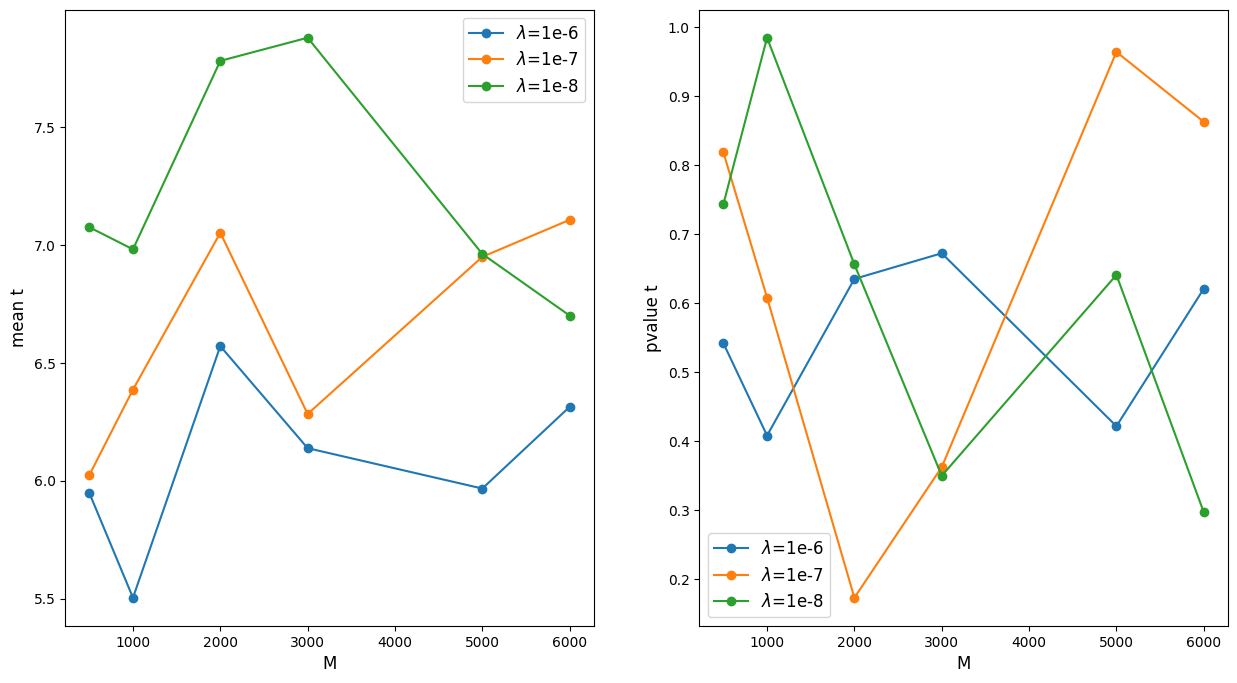

In [12]:
path  = "/home/ubuntu/NPLM-Falkon/output/1D/2024_2_19"
path2 = "/home/ubuntu/NPLM-Falkon/output/1D/2024_2_20_14-9_"
fig, ax = plt.subplots(figsize=(15,8), ncols=2)
ax[0].plot(M_list,read_data(1e-6, 'mean', path=path), marker='o', markersize=6 , label="$\lambda$=1e-6")
ax[0].plot(M_list,read_data(1e-7, 'mean', path=path), marker='o', markersize=6 , label="$\lambda$=1e-7")
ax[0].plot(M_list,read_data(1e-8, 'mean', path=path), marker='o', markersize=6 , label="$\lambda$=1e-8")

ax[0].set_xlabel('M', fontsize=12)
ax[0].set_ylabel('mean t', fontsize=12)
ax[0].legend(fontsize =12)


ax[1].plot(M_list,read_data(1e-6, 'pvalue', path=path), marker='o', markersize=6 , label="$\lambda$=1e-6")
ax[1].plot(M_list,read_data(1e-7, 'pvalue', path=path), marker='o', markersize=6 , label="$\lambda$=1e-7")
ax[1].plot(M_list,read_data(1e-8, 'pvalue', path=path), marker='o', markersize=6 , label="$\lambda$=1e-8")

ax[1].set_xlabel('M', fontsize=12)
ax[1].set_ylabel('pvalue t', fontsize=12)
ax[1].legend(fontsize =12)
# plt.savefig("../plot/1D/pvalue_vs_M.png")


### Investigate distributions

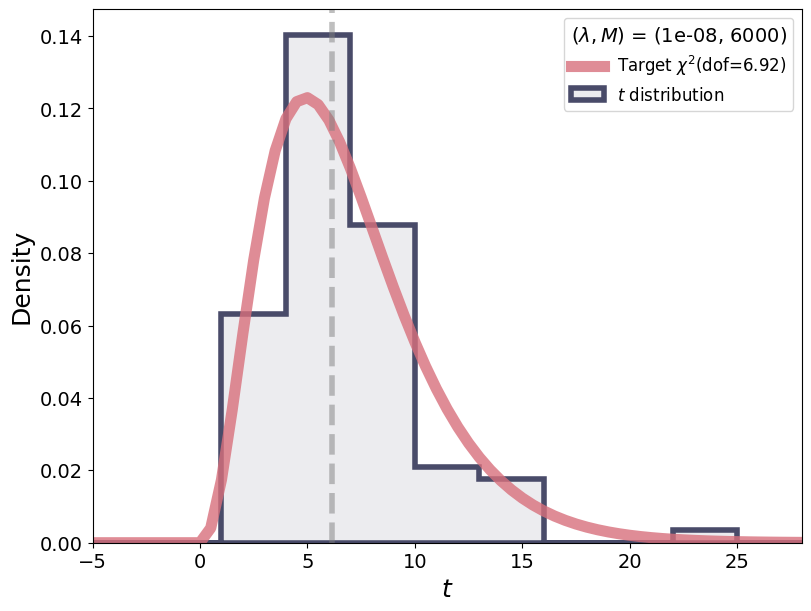

In [16]:
l=1e-8
m=6000
distrib_path = '/home/ubuntu/NPLM-Falkon/output/1D/2024_2_19/ttest_time_'+str(l)+'_'+str(m)+'.csv'
with open(distrib_path) as f:
    t_list = np.array([float(row.split()[0]) for row in f])
            
df_fit, loc, scale = chi2.fit(t_list, floc=0, fscale=1)
ref_chi2 = chi2(df=df_fit)
t_ref_bins  = np.arange(-5, 30, 3)
xgrid_ref   = np.arange(-5, 30, 0.5)

plot_one_t(
    t_distribution  = t_list,
    t_bins          = t_ref_bins,
    chi2            = ref_chi2,
    chi2_grid       = xgrid_ref,
    show_hist       = True,
    show_error      = False,
    compute_rate    = False,
    err_marker      = "o",
    err_markersize  = 10,
    err_capsize     = 5,
    err_elinewidth  = 4,
    err_capthick    = 4,
    err_color       = "black",
    figsize         = (8, 6),
    fontsize        = 18,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    hist_ecolor     = ("#494B69", 1.0),
    hist_fcolor     = ("#494B69", 0.1),
    chi2_color      = ("#D8707C", 0.8),
    hist_lw         = 4,
    chi2_lw         = 8,
    hist_type       = "stepfilled",
    hist_label      = "$\it{t}$ distribution",
    chi2_label      = "Target $\chi^2$(dof=%.2f)"%(df_fit),
    xlabel          = r"$t$",
    ylabel          = "Density",
    show_plot       = True,
    save_plot       = False,
    plot_name       = "t_distribution_"+str(l)+"_"+str(m),
    plot_path       = "/home/ubuntu/NPLM-Falkon/plot/1D/",
    plot_format     = "png",
    return_fig      = False,
    plot_params     = True,
    hyperparams     = str(l)+", "+str(m),
)


    

## new training analysis

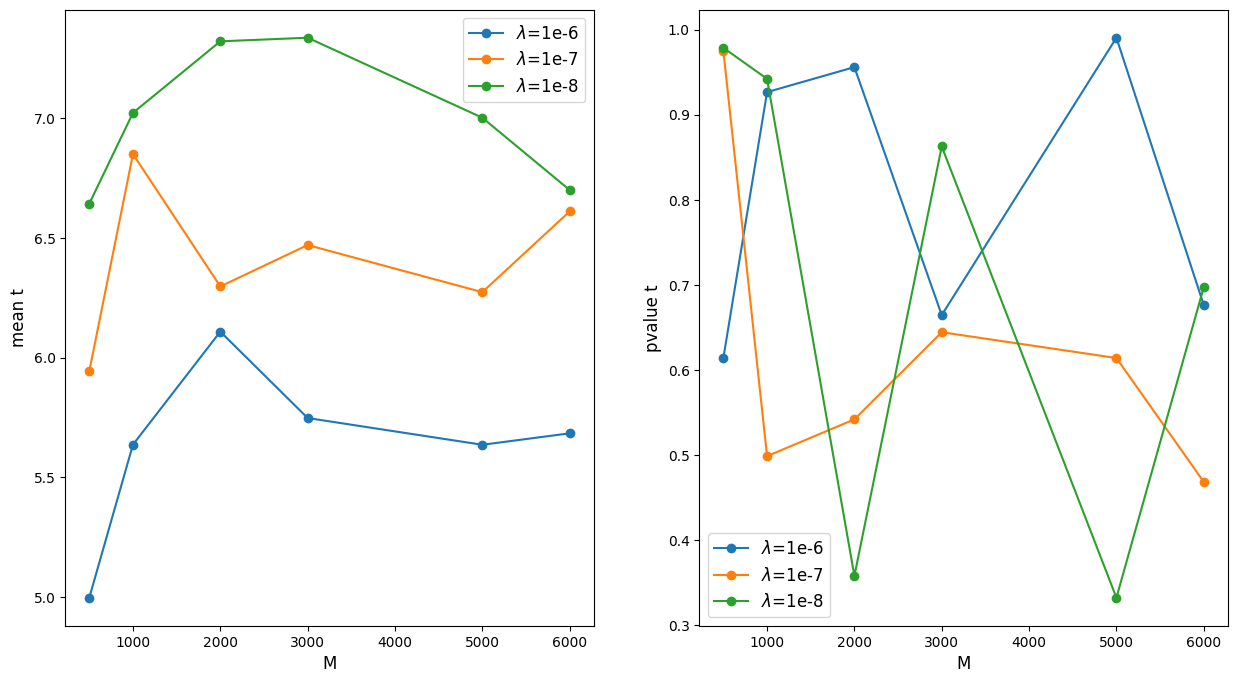

In [14]:
path  = "/home/ubuntu/NPLM-Falkon/output/1D/2024_2_27_11_11"
fig, ax = plt.subplots(figsize=(15,8), ncols=2)
ax[0].plot(M_list,read_data(1e-6, 'mean', path=path), marker='o', markersize=6 , label="$\lambda$=1e-6")
ax[0].plot(M_list,read_data(1e-7, 'mean', path=path), marker='o', markersize=6 , label="$\lambda$=1e-7")
ax[0].plot(M_list,read_data(1e-8, 'mean', path=path), marker='o', markersize=6 , label="$\lambda$=1e-8")

ax[0].set_xlabel('M', fontsize=12)
ax[0].set_ylabel('mean t', fontsize=12)
ax[0].legend(fontsize =12)


ax[1].plot(M_list,read_data(1e-6, 'pvalue', path=path), marker='o', markersize=6 , label="$\lambda$=1e-6")
ax[1].plot(M_list,read_data(1e-7, 'pvalue', path=path), marker='o', markersize=6 , label="$\lambda$=1e-7")
ax[1].plot(M_list,read_data(1e-8, 'pvalue', path=path), marker='o', markersize=6 , label="$\lambda$=1e-8")

ax[1].set_xlabel('M', fontsize=12)
ax[1].set_ylabel('pvalue t', fontsize=12)
ax[1].legend(fontsize =12)

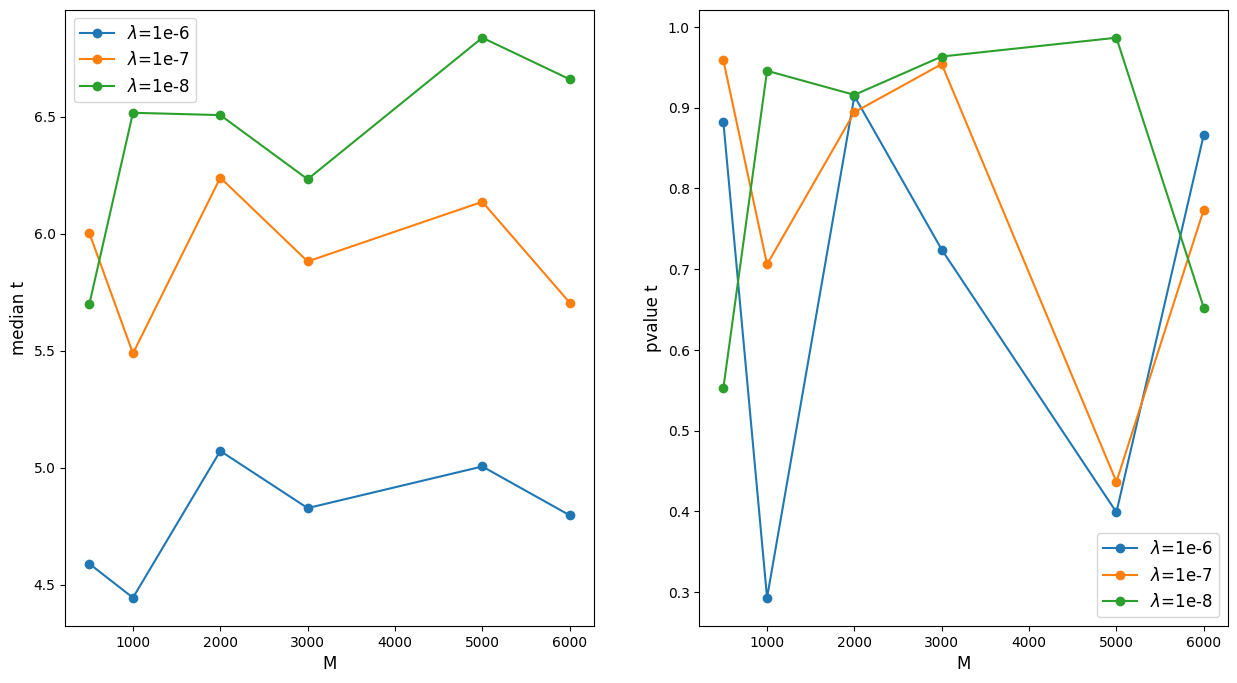

In [18]:
path  = "/home/ubuntu/NPLM-Falkon/output/1D/2024_2_27_13_24"
fig, ax = plt.subplots(figsize=(15,8), ncols=2)
ax[0].plot(M_list,read_data(1e-6, 'median', path=path), marker='o', markersize=6 , label="$\lambda$=1e-6")
ax[0].plot(M_list,read_data(1e-7, 'median', path=path), marker='o', markersize=6 , label="$\lambda$=1e-7")
ax[0].plot(M_list,read_data(1e-8, 'median', path=path), marker='o', markersize=6 , label="$\lambda$=1e-8")

ax[0].set_xlabel('M', fontsize=12)
ax[0].set_ylabel('median t', fontsize=12)
ax[0].legend(fontsize =12)


ax[1].plot(M_list,read_data(1e-6, 'pvalue', path=path), marker='o', markersize=6 , label="$\lambda$=1e-6")
ax[1].plot(M_list,read_data(1e-7, 'pvalue', path=path), marker='o', markersize=6 , label="$\lambda$=1e-7")
ax[1].plot(M_list,read_data(1e-8, 'pvalue', path=path), marker='o', markersize=6 , label="$\lambda$=1e-8")

ax[1].set_xlabel('M', fontsize=12)
ax[1].set_ylabel('pvalue t', fontsize=12)
ax[1].legend(fontsize =12)